In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# 데이터 로드
df = pd.read_csv('train.csv')

# --- [STEP 1] 순서형 변수(Ordinal) 수동 매핑 ---
# 품질과 상태를 나타내는 변수들을 숫자로 변환합니다.
qual_map = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, 'NA': 0}
exposure_map = {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, 'NA': 0}
finish_map = {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, 'NA': 0}

# 매핑할 컬럼 리스트 분류
qual_cols = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 
             'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond', 'PoolQC']
exposure_cols = ['BsmtExposure']
finish_cols = ['BsmtFinType1', 'BsmtFinType2']

# 매핑 적용 (결측치는 'NA'로 간주)
for col in qual_cols:
    df[col] = df[col].fillna('NA').map(qual_map)

for col in exposure_cols:
    df[col] = df[col].fillna('NA').map(exposure_map)

for col in finish_cols:
    df[col] = df[col].fillna('NA').map(finish_map)

# --- [STEP 2] 명목형 변수(Nominal) Label Encoding ---
# 순서가 없는 나머지 문자열 변수들을 처리합니다.
le = LabelEncoder()

# 아직 object 타입으로 남아있는 컬럼들만 선택
nominal_cols = df.select_dtypes(include=['object']).columns

for col in nominal_cols:
    # 결측치를 'None'이라는 문자열로 채워 인코딩 에러 방지
    df[col] = df[col].fillna('None')
    df[col] = le.fit_transform(df[col])

# --- [STEP 3] 수치형 변수 결측치 처리 ---
# 나머지 수치형 변수들의 결측치도 중앙값으로 채워 마무리합니다.
df = df.fillna(df.median())

print("전처리 완료! 모든 컬럼이 수치형으로 변환되었습니다.")
print(df.info())

전처리 완료! 모든 컬럼이 수치형으로 변환되었습니다.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   int64  
 3   LotFrontage    1460 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   int64  
 6   Alley          1460 non-null   int64  
 7   LotShape       1460 non-null   int64  
 8   LandContour    1460 non-null   int64  
 9   Utilities      1460 non-null   int64  
 10  LotConfig      1460 non-null   int64  
 11  LandSlope      1460 non-null   int64  
 12  Neighborhood   1460 non-null   int64  
 13  Condition1     1460 non-null   int64  
 14  Condition2     1460 non-null   int64  
 15  BldgType       1460 non-null   int64  
 16  HouseStyle     1460 non-null   int64  
 17  OverallQual    1460 no

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# 분석에 사용할 특성 선택 (Id와 타겟 SalePrice 제외)
features = df.drop(['Id', 'SalePrice'], axis=1)

vif_data = pd.DataFrame()
vif_data["feature"] = features.columns
vif_data["VIF"] = [variance_inflation_factor(features.values, i) 
                   for i in range(len(features.columns))]

print(vif_data.sort_values(by="VIF", ascending=False).head(10))

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


         feature           VIF
33    BsmtFinSF1           inf
42      1stFlrSF           inf
37   TotalBsmtSF           inf
36     BsmtUnfSF           inf
45     GrLivArea           inf
35    BsmtFinSF2           inf
43      2ndFlrSF           inf
44  LowQualFinSF           inf
76        YrSold  4.809015e+04
18     YearBuilt  3.446206e+04


In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. 독립변수(X)와 종속변수(y) 설정 (SalePrice에 로그 변환 적용)
X = df.drop(['Id', 'SalePrice'], axis=1)
y_log = np.log1p(df['SalePrice'])

# 2. 데이터 분할 (8:2)
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 3. 랜덤 포레스트 모델 생성 및 학습
# n_estimators: 나무의 개수, random_state: 결과 재현을 위한 난수 고정
rf_final = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
rf_final.fit(X_train, y_train_log)

# 4. 예측 및 역로그 변환 (지수함수 적용)
y_pred_log = rf_final.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_test = np.expm1(y_test_log)

# 5. 성능 평가
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"--- 새 전처리 방식 적용 결과 ---")
print(f"RMSE (평균 제곱근 오차): ${rmse:,.2f}")
print(f"R2 Score (결정계수): {r2:.4f}")

--- 새 전처리 방식 적용 결과 ---
RMSE (평균 제곱근 오차): $28,978.20
R2 Score (결정계수): 0.8905


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26700\1884966922.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feat_importances.values, y=feat_importances.index, palette='magma')


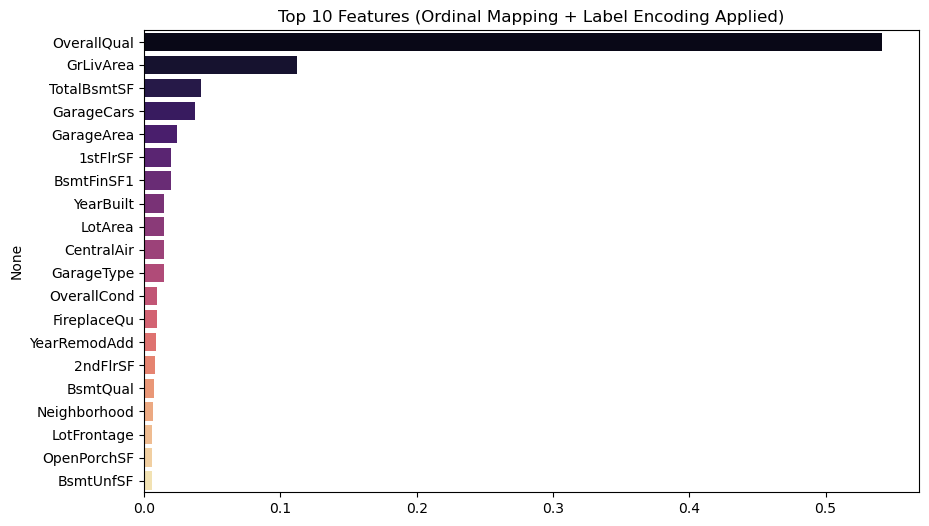

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# 중요도 추출
importances = rf_final.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False).head(20)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=feat_importances.values, y=feat_importances.index, palette='magma')
plt.title('Top 10 Features (Ordinal Mapping + Label Encoding Applied)')
plt.show()

In [7]:
# 모든 변수와 SalePrice 간의 상관계수 계산
correlations = df.corr()['SalePrice'].sort_values(ascending=False)

print("--- 집값(SalePrice)과 상관계수가 높은 상위 20개 변수 ---")
print(correlations.head(21)) # SalePrice 자신을 포함하여 21개

print("\n--- 집값(SalePrice)과 음의 상관계수가 높은 하위 10개 변수 ---")
print(correlations.tail(10))

--- 집값(SalePrice)과 상관계수가 높은 상위 20개 변수 ---
SalePrice       1.000000
OverallQual     0.790982
GrLivArea       0.708624
ExterQual       0.682639
KitchenQual     0.659600
GarageCars      0.640409
GarageArea      0.623431
TotalBsmtSF     0.613581
1stFlrSF        0.605852
BsmtQual        0.585207
FullBath        0.560664
TotRmsAbvGrd    0.533723
YearBuilt       0.522897
FireplaceQu     0.520438
YearRemodAdd    0.507101
MasVnrArea      0.472614
Fireplaces      0.466929
GarageYrBlt     0.466754
HeatingQC       0.427649
BsmtFinSF1      0.386420
Foundation      0.382479
Name: SalePrice, dtype: float64

--- 집값(SalePrice)과 음의 상관계수가 높은 하위 10개 변수 ---
OverallCond     -0.077856
MSSubClass      -0.084284
BldgType        -0.085591
Heating         -0.098812
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
MSZoning        -0.166872
LotShape        -0.255580
GarageType      -0.415283
GarageFinish    -0.425684
Name: SalePrice, dtype: float64


In [15]:
# 이상치 제거 전 데이터 개수 확인
print(f"제거 전 데이터 개수: {len(df)}")

# GrLivArea가 4000보다 크지만 SalePrice가 300,000 미만인 데이터 제거
outliers = df[(df['GrLivArea'] > 4000) & (df['SalePrice'] < 300000)].index
df = df.drop(outliers)

print(f"제거 후 데이터 개수: {len(df)} (제거된 인덱스: {list(outliers)})")

제거 전 데이터 개수: 1460
제거 후 데이터 개수: 1458 (제거된 인덱스: [523, 1298])


In [16]:
from scipy import stats

# SalePrice 기준 Z-Score가 3이 넘는(극단적 고가 주택 등) 데이터 식별
z_scores = np.abs(stats.zscore(df['SalePrice']))
df = df[z_scores < 3]

print(f"통계적 이상치 제거 후 데이터 개수: {len(df)}")

통계적 이상치 제거 후 데이터 개수: 1436


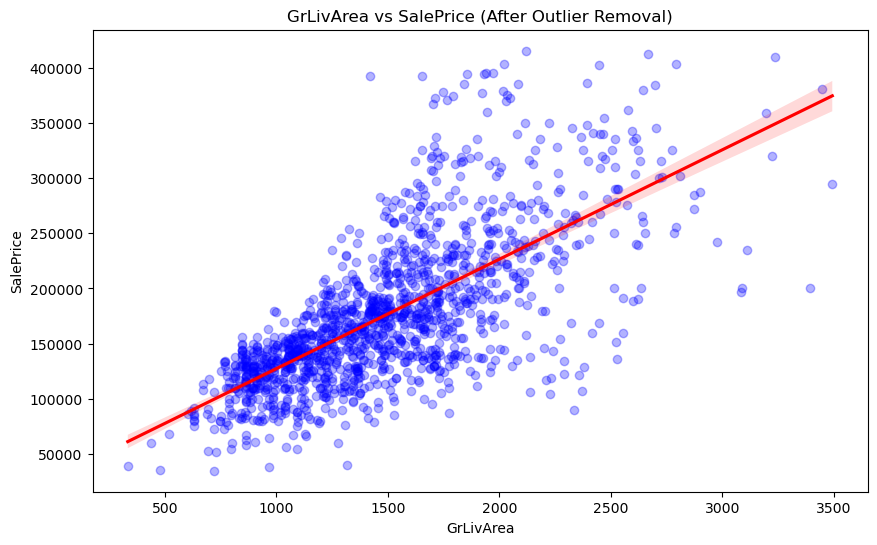

In [17]:
plt.figure(figsize=(10, 6))
sns.regplot(x=df['GrLivArea'], y=df['SalePrice'], 
            scatter_kws={'alpha':0.3, 'color':'blue'}, 
            line_kws={'color':'red'})
plt.title('GrLivArea vs SalePrice (After Outlier Removal)')
plt.show()

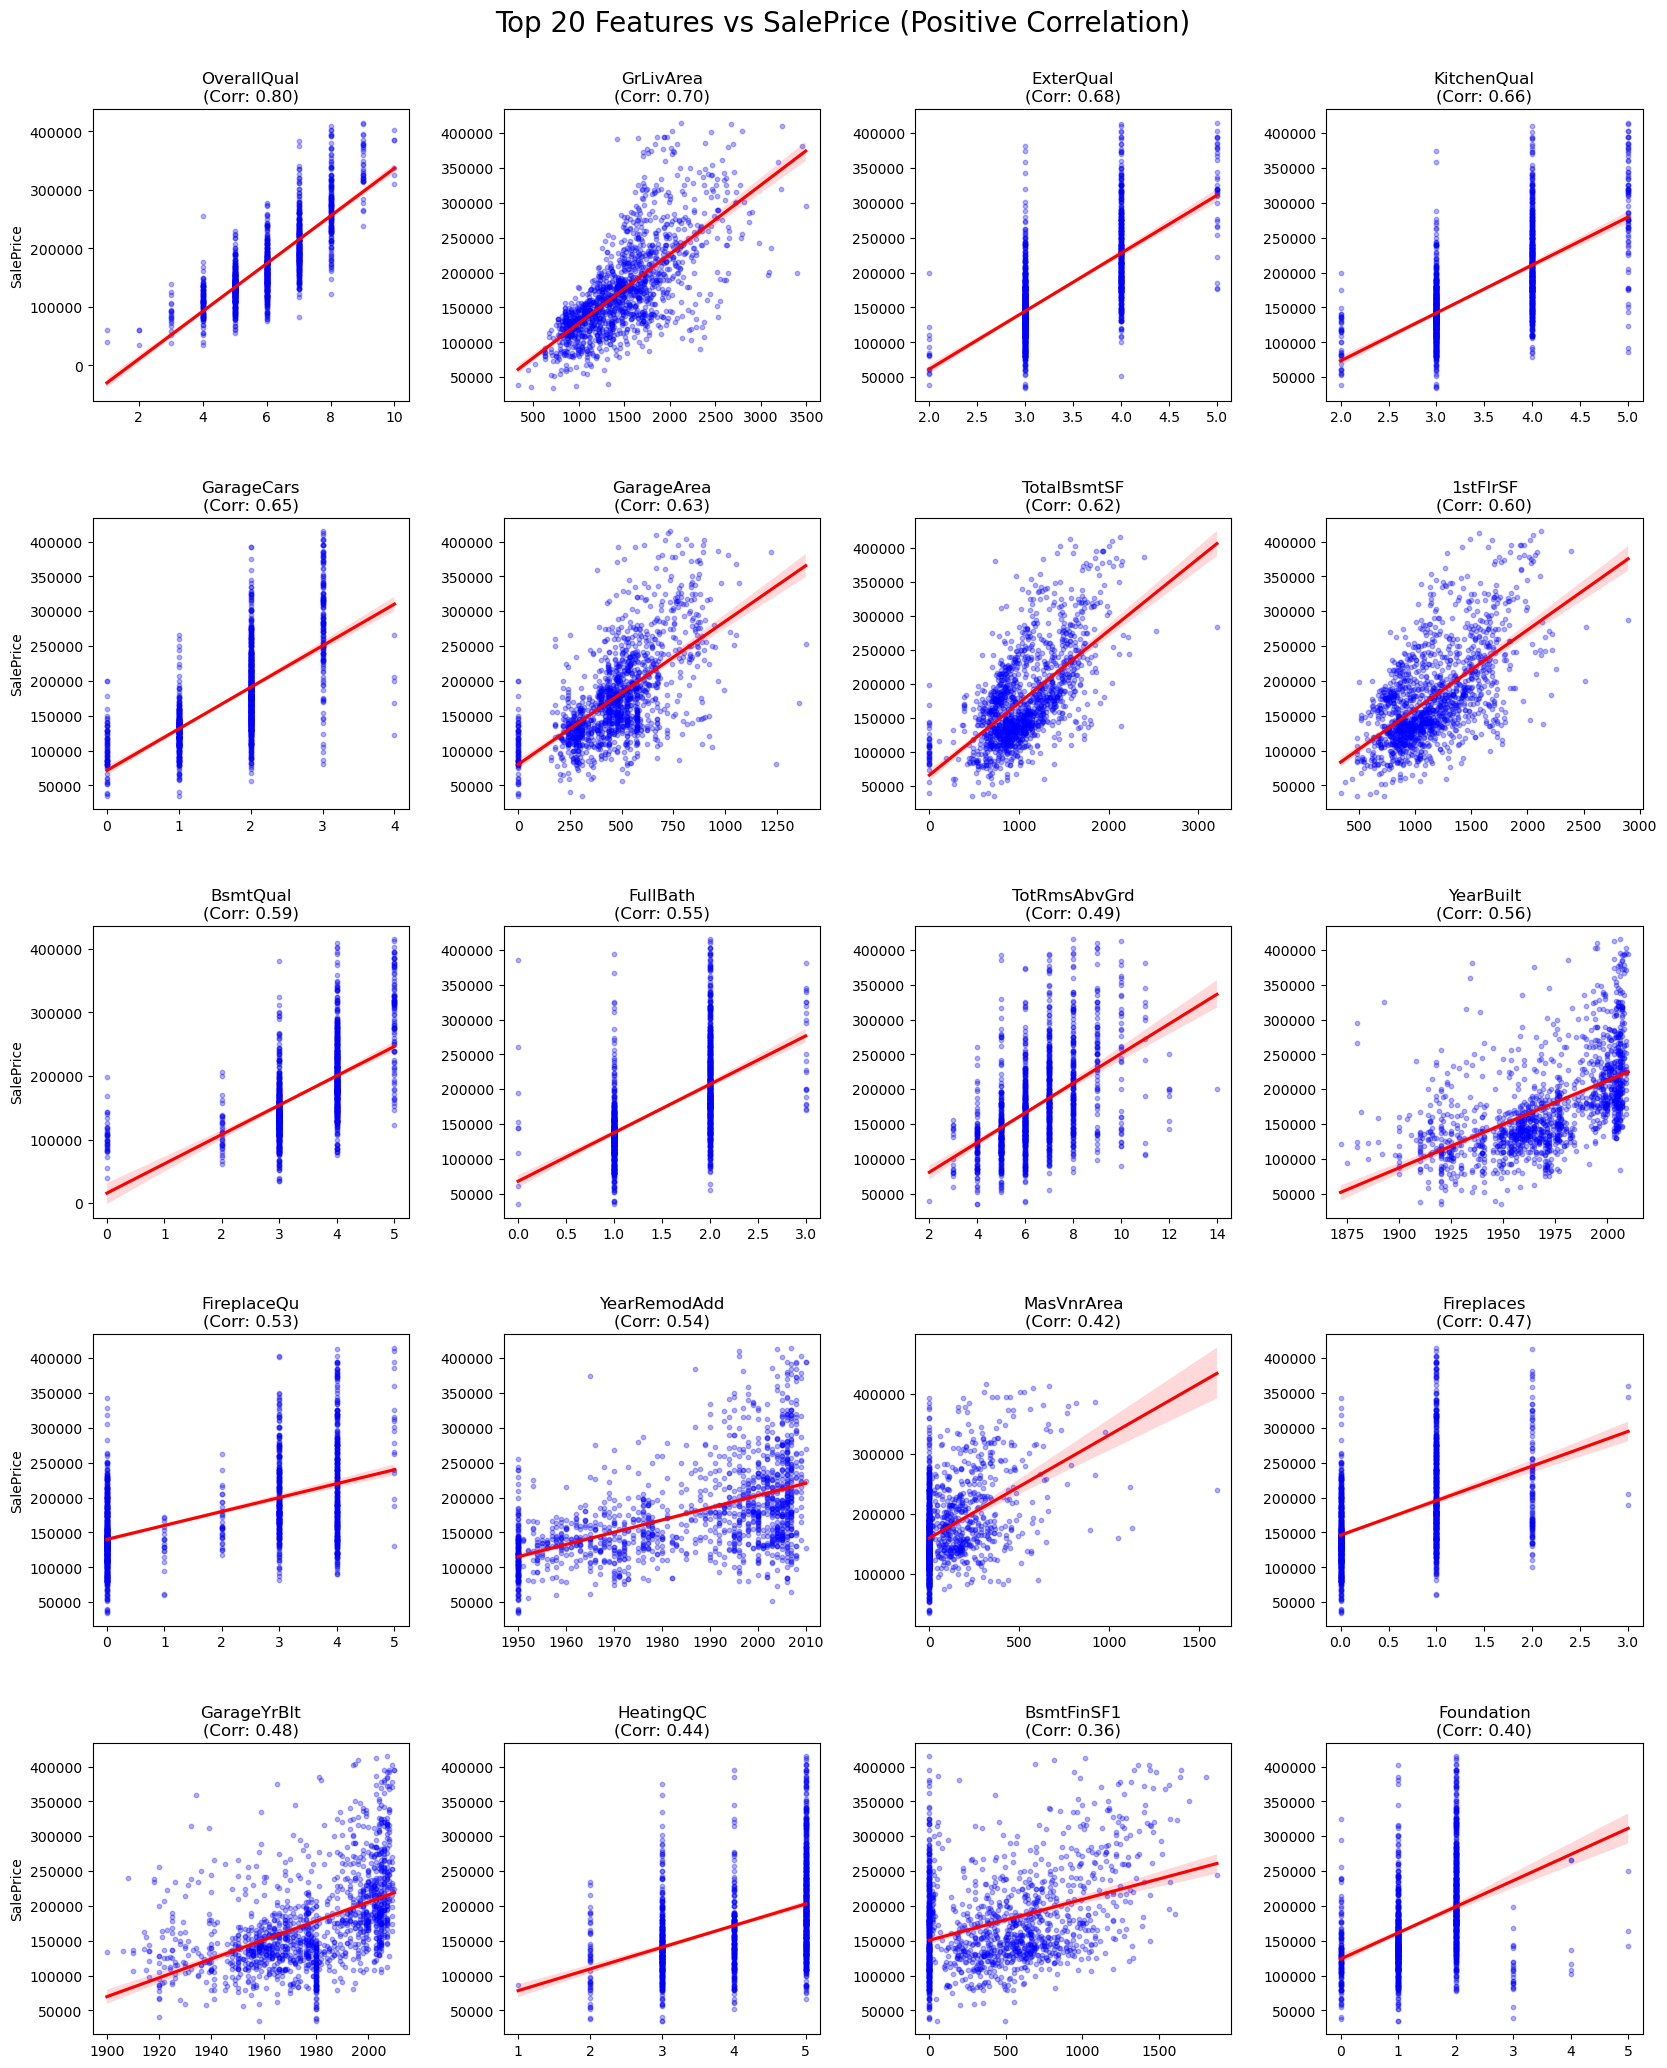

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

# 1. 상위 20개 변수 추출 (SalePrice 제외)
top_20_features = correlations.iloc[1:21].index.tolist()

# 2. 시각화 설정 (5행 4열)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 25))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle('Top 20 Features vs SalePrice (Positive Correlation)', fontsize=20, y=0.92)

axes = axes.flatten()

for i, col in enumerate(top_20_features):
    # regplot은 산점도와 회귀선을 동시에 그려줍니다.
    sns.regplot(x=df[col], y=df['SalePrice'], ax=axes[i], 
                scatter_kws={'alpha':0.3, 's':10, 'color':'blue'}, 
                line_kws={'color':'red'})
    axes[i].set_title(f'{col}\n(Corr: {df[col].corr(df["SalePrice"]):.2f})', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('SalePrice' if i % 4 == 0 else '')

plt.show()

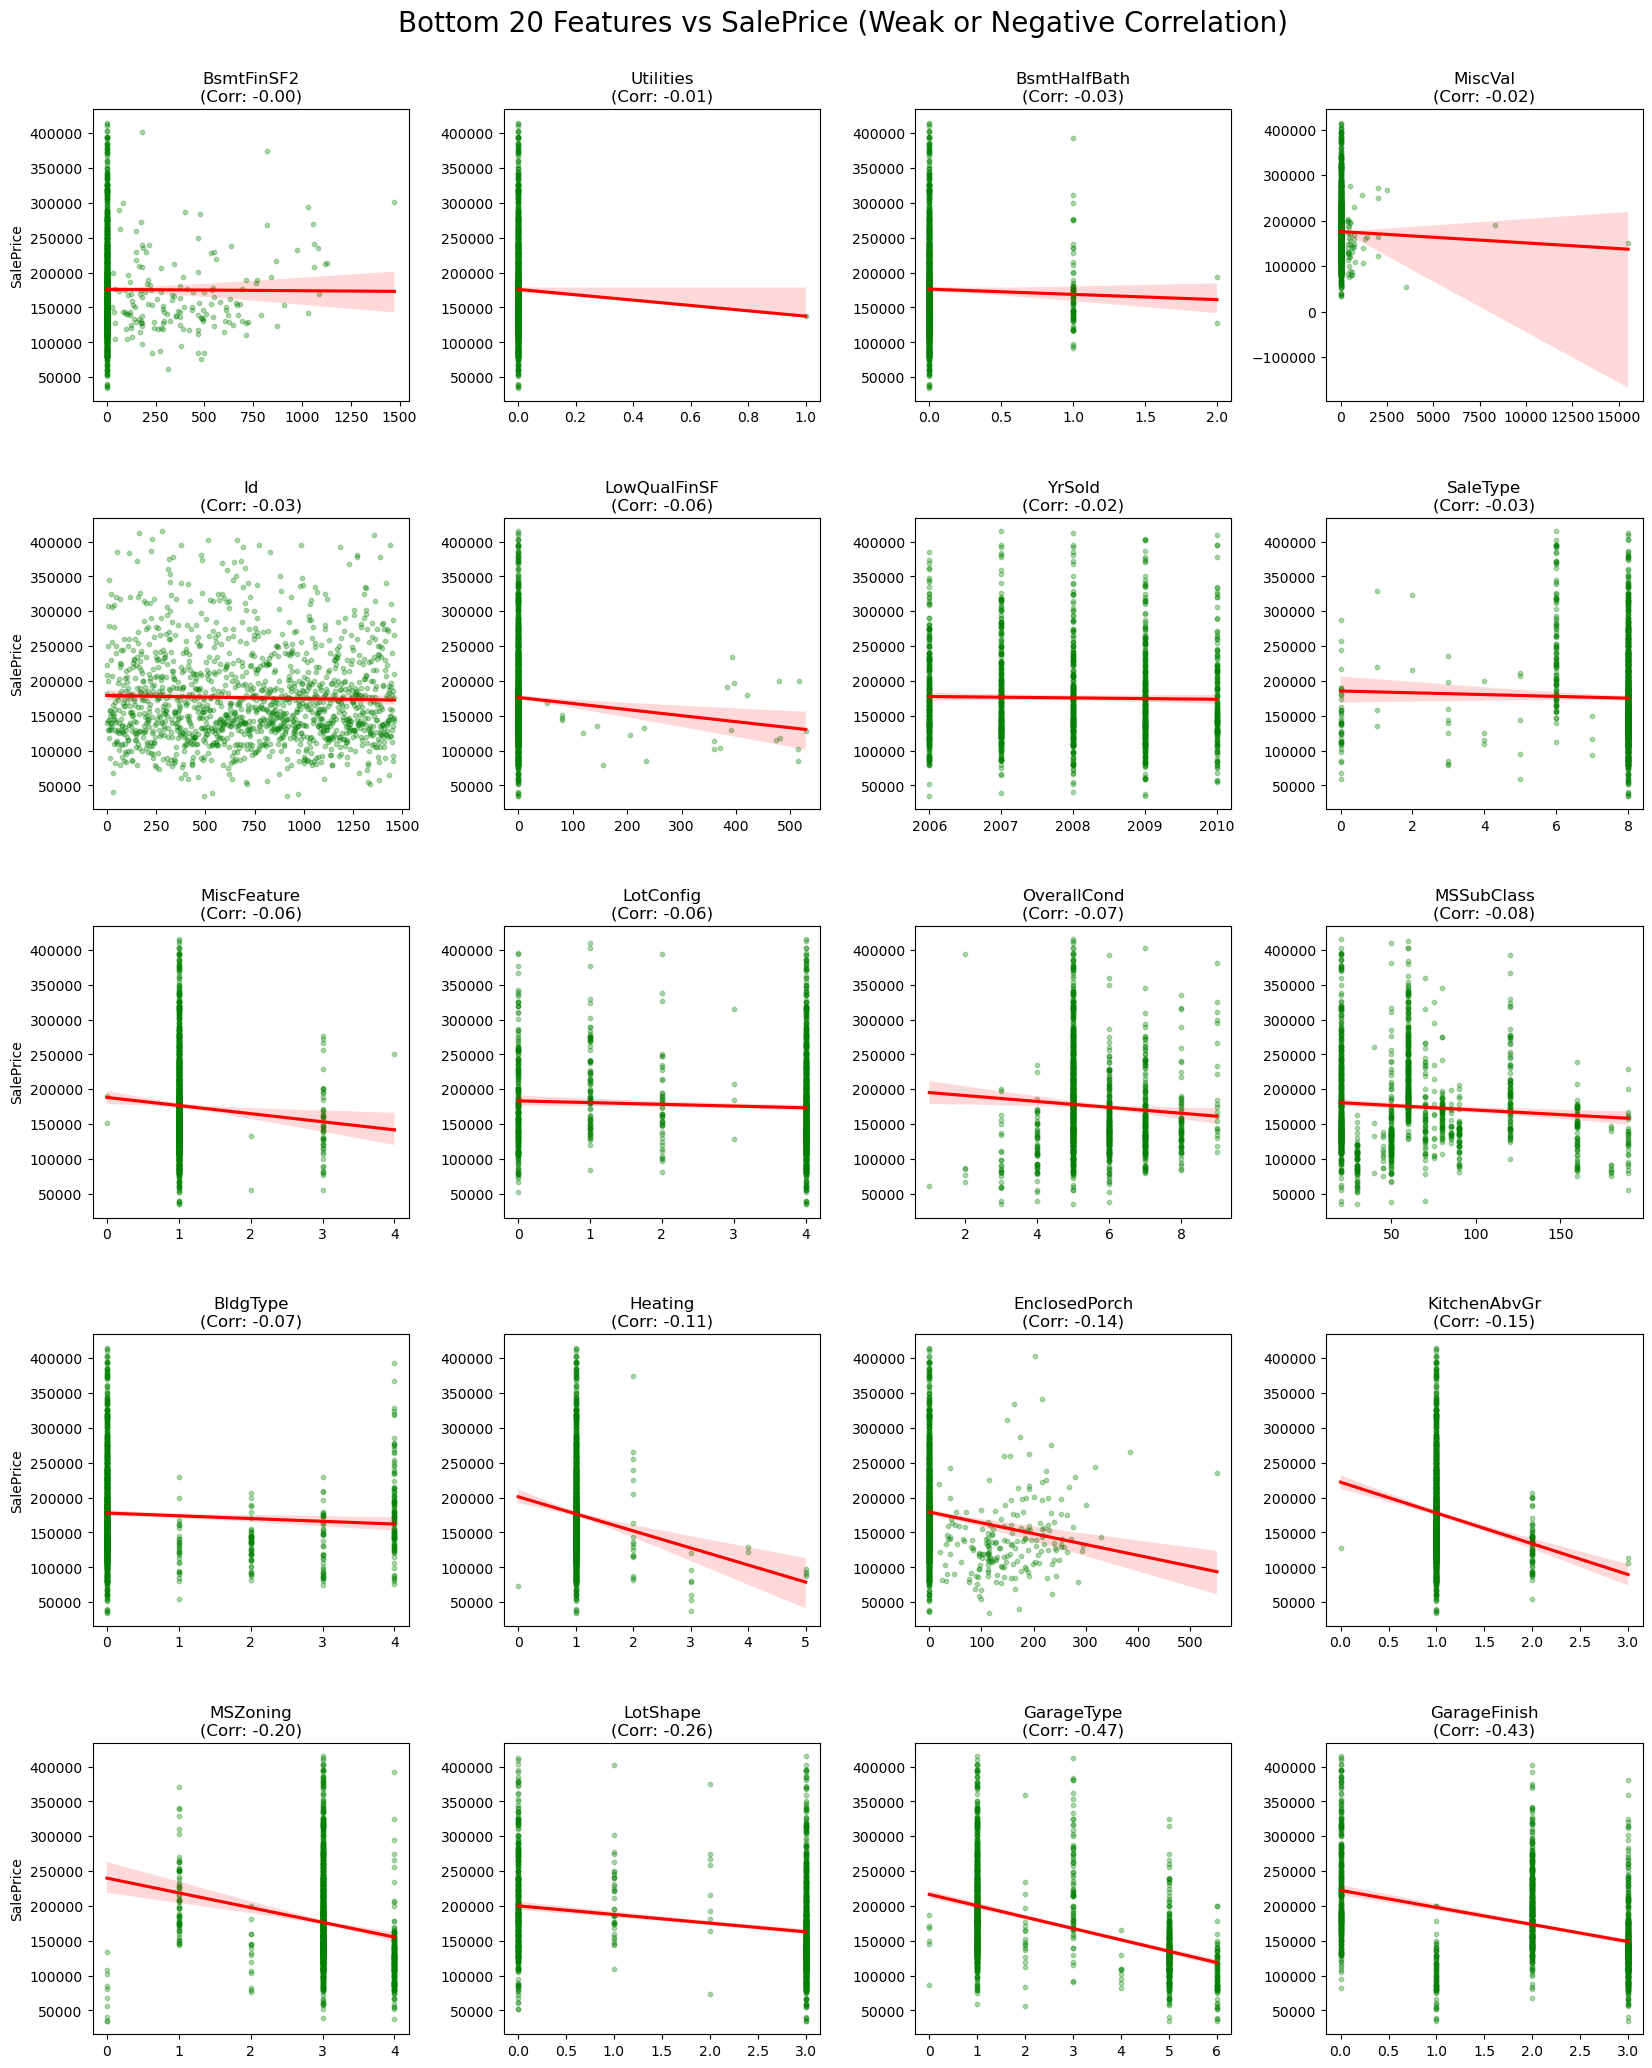

In [19]:
# 1. 하위 20개 변수 추출
bottom_20_features = correlations.tail(20).index.tolist()

# 2. 시각화 설정 (5행 4열)
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20, 25))
plt.subplots_adjust(hspace=0.4, wspace=0.3)
fig.suptitle('Bottom 20 Features vs SalePrice (Weak or Negative Correlation)', fontsize=20, y=0.92)

axes = axes.flatten()

for i, col in enumerate(bottom_20_features):
    sns.regplot(x=df[col], y=df['SalePrice'], ax=axes[i], 
                scatter_kws={'alpha':0.3, 's':10, 'color':'green'}, 
                line_kws={'color':'red'})
    axes[i].set_title(f'{col}\n(Corr: {df[col].corr(df["SalePrice"]):.2f})', fontsize=12)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('SalePrice' if i % 4 == 0 else '')

plt.show()

In [21]:
# 선형회기계수
from sklearn.linear_model import LinearRegression

# 모델 학습 (X_train, y_train_log는 이전 전처리 데이터 사용)
lr_model = LinearRegression()
lr_model.fit(X_train, y_train_log)

# 회귀계수와 절편 추출
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
}).sort_values(by='Coefficient', ascending=False)

print(f"절편(Intercept): {lr_model.intercept_:.4f}")
print(coefficients.head(10)) # 가장 영향력이 큰 상위 10개 변수

절편(Intercept): 17.6107
         Feature  Coefficient
16   OverallQual     0.063307
40    CentralAir     0.061084
60    GarageCars     0.056558
46  BsmtFullBath     0.054140
10     LandSlope     0.040007
29      BsmtQual     0.038674
17   OverallCond     0.037852
4         Street     0.035408
48      FullBath     0.032453
49      HalfBath     0.023867


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26700\2137637591.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=top_10_coef, palette='viridis')


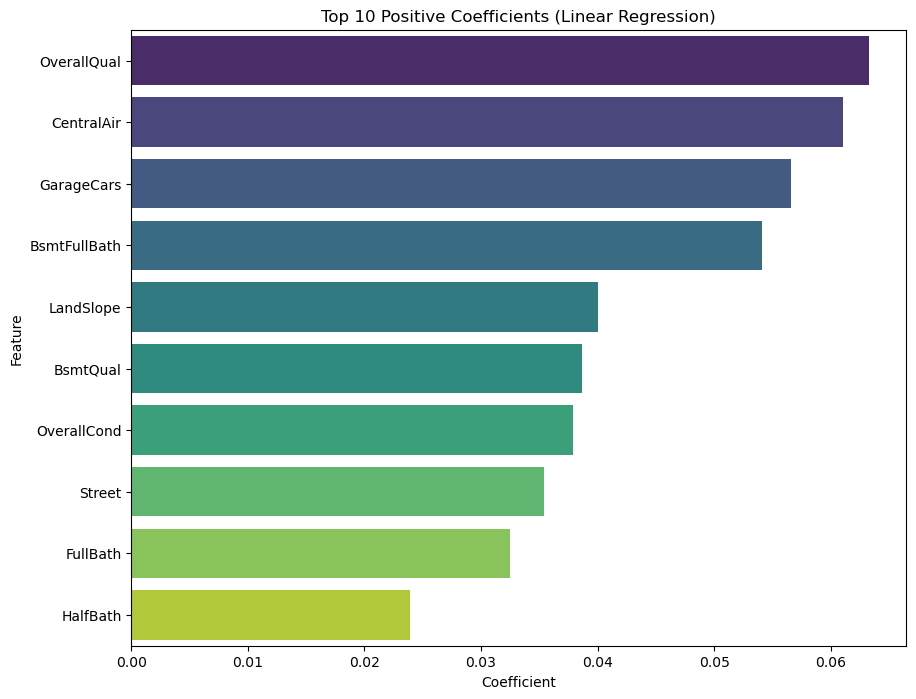

In [22]:
plt.figure(figsize=(10, 8))
top_10_coef = coefficients.head(10)
sns.barplot(x='Coefficient', y='Feature', data=top_10_coef, palette='viridis')
plt.title('Top 10 Positive Coefficients (Linear Regression)')
plt.show()

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26700\3939365684.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Neighborhood', y='SalePrice', data=df_visual, order=order, palette='Spectral')


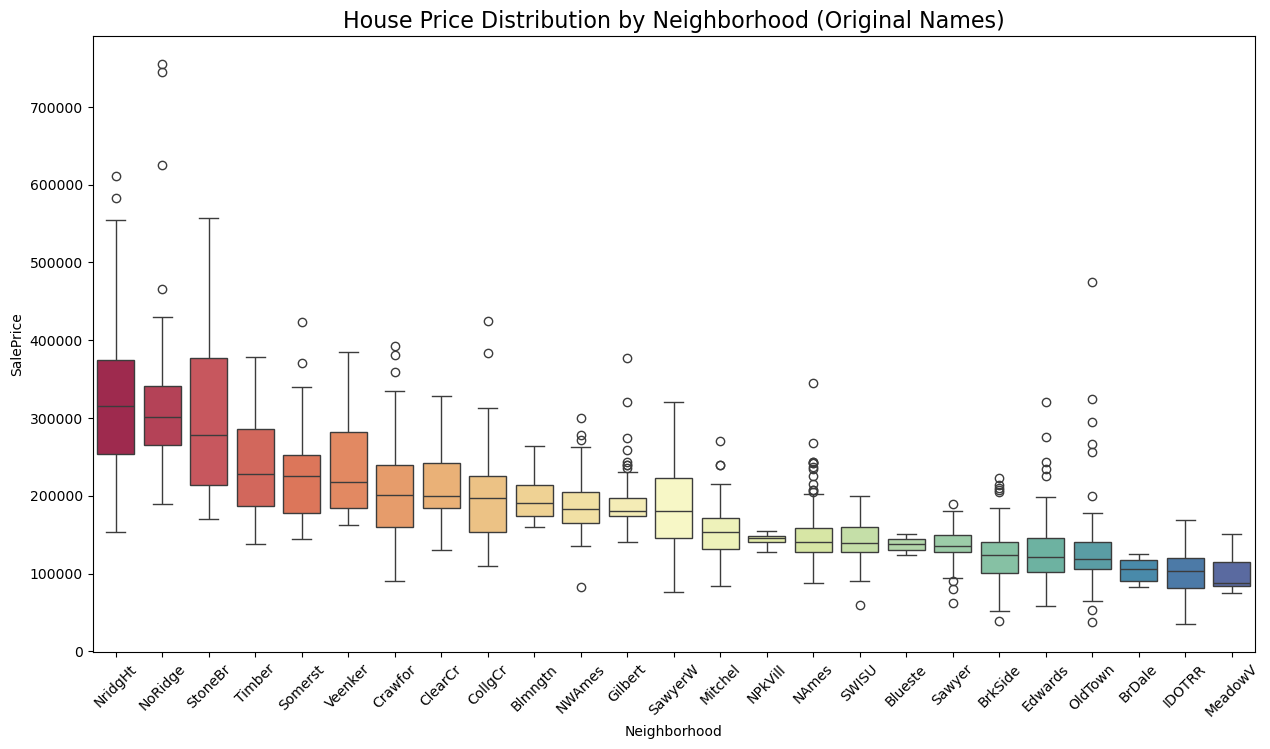

In [31]:
# 1. 시각화 전용 데이터프레임 생성 (인코딩 전 상태라고 가정)
# 만약 이미 df를 수정해버렸다면, train.csv를 다시 로드하는 것이 빠릅니다.
df_visual = pd.read_csv('train.csv') 

# 2. 지역별 중앙값 계산 및 정렬
order = df_visual.groupby('Neighborhood')['SalePrice'].median().sort_values(ascending=False).index

# 3. 시각화
plt.figure(figsize=(15, 8))
sns.boxplot(x='Neighborhood', y='SalePrice', data=df_visual, order=order, palette='Spectral')

plt.xticks(rotation=45)
plt.title('House Price Distribution by Neighborhood (Original Names)', fontsize=16)
plt.show()

In [34]:
def predict_remodeling_impact(model, house_data, remodeling_plan):
    """
    model: 학습된 랜덤 포레스트 모델
    house_data: 리모델링 전 집의 정보 (1행 데이터프레임)
    remodeling_plan: 변경하고 싶은 컬럼과 값 (딕셔너리)
    """
    # 1. 원본 예측 (로그 변환 고려)
    original_pred_log = model.predict(house_data)
    original_price = np.expm1(original_pred_log)[0]
    
    # 2. 데이터 복사 및 리모델링 적용
    remodeled_data = house_data.copy()
    for col, new_value in remodeling_plan.items():
        remodeled_data[col] = new_value
        
    # 3. 리모델링 후 예측
    remodeled_pred_log = model.predict(remodeled_data)
    remodeled_price = np.expm1(remodeled_pred_log)[0]
    
    # 4. 결과 계산
    increase = remodeled_price - original_price
    percent_increase = (increase / original_price) * 100
    
    return original_price, remodeled_price, increase, percent_increase

In [35]:
# 분석 대상 집 선정
sample_house = X_test.iloc[[0]]

# 리모델링 계획: 부엌 품질(KitchenQual)과 난방 품질(HeatingQC)을 'Excellent(5)'로 업그레이드
# (우리가 앞에서 설정한 매핑: Ex=5, Gd=4, TA=3...)
my_plan = {
    'KitchenQual': 5, 
    'HeatingQC': 5,
    'YearRemodAdd': 2026  # 리모델링 연도도 최신으로 업데이트
}

orig, new, diff, pct = predict_remodeling_impact(rf_final, sample_house, my_plan)

print(f"--- 🛠️ 리모델링 시뮬레이션 결과 ---")
print(f"현재 예상가: ${orig:,.0f}")
print(f"리모델링 후 예상가: ${new:,.0f}")
print(f"💰 예상 상승 가치: ${diff:,.0f} ({pct:.2f}% 상승)")

--- 🛠️ 리모델링 시뮬레이션 결과 ---
현재 예상가: $138,886
리모델링 후 예상가: $139,581
💰 예상 상승 가치: $695 (0.50% 상승)


C:\Users\ADMIN\AppData\Local\Temp\ipykernel_26700\3103842246.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(impacts.values()), y=list(impacts.keys()), palette='viridis')


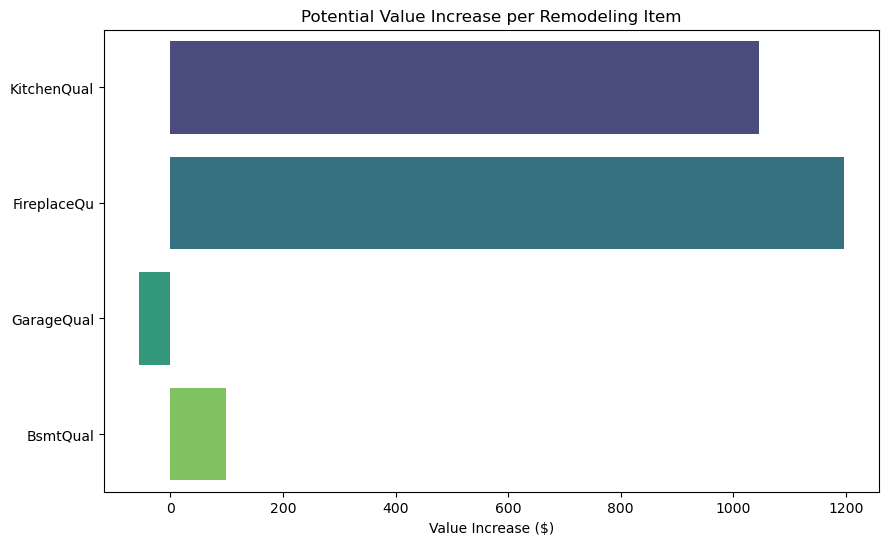

In [36]:
# 가성비 분석: 항목별 단독 개선 효과
features_to_test = {
    'KitchenQual': 5,
    'FireplaceQu': 5,
    'GarageQual': 5,
    'BsmtQual': 5
}

impacts = {}
for feat, val in features_to_test.items():
    _, _, diff, _ = predict_remodeling_impact(rf_final, sample_house, {feat: val})
    impacts[feat] = diff

# 결과 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=list(impacts.values()), y=list(impacts.keys()), palette='viridis')
plt.title('Potential Value Increase per Remodeling Item')
plt.xlabel('Value Increase ($)')
plt.show()